
# 瑕疵檢測簡介
* 發展智慧工廠已經成為全球產業的趨勢，但對產業來說無論工廠如何演進，品質和良率都是無法避免且必須解決的問題
* 對應產業的需要，機器視覺常被使用於工業檢測、尺寸量測、自動化導引等用途
* 近年來隨著深度學習技術的發展，AI技術紛紛導入產業應用，AI瑕疵檢測使用深度學習技術將成為下一波發展重點與智慧製造商機所在
* 深度學習技術改善傳統光學檢測（AOI）難以檢測的不規律瑕疵及特徵，有效解決刮痕、污垢、裂縫、缺件、變型和歪曲的字體以及無固定顏色、大小、形狀等難以依賴光學架構與影像處理來突顯及分離之瑕疵和特徵



<img src="img/傳統AOI流程.jpg" alt="architecture"/>



## 現行AOI如何減少人力與提高準確率

* 原本全人工檢查
* 自動化檢查配合人工複檢
* 新創應用

<img src="img/AOI如何減少人力提高準確率.jpg" width="90%" height="90%" alt="architecture"/>

## 以深度學習加值AOI應用

## 安裝與導入套件

note:只有初始建立容器時由於附加外掛工具，才需要重啟jupyter: 1.按Quit鍵結束jp nb, 2.ssh登入後重啟 $jupyter notebook.

In [1]:
!sudo pip install matplotlib
!sudo pip install Pillow
!sudo pip install keras_tqdm
!sudo pip install sklearn
!sudo pip install jupyter_contrib_nbextensions 
!sudo jupyter contrib nbextension install
!pip install autopep8
!sudo pip install -U jupyter

[I 11:34:13 InstallContribNbextensionsApp] jupyter contrib nbextension install 
[I 11:34:13 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 11:34:13 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbextensions/addbefore -> addbefore
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/addbefore/addbefore.yaml
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/addbefore/icon.png
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/addbefore/main.js
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/addbefore/readme.md
[I 11:34:13 InstallContribNbextensionsApp] - Validating: OK
[I 11:34:13 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions

[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/rubberband/icon.png
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/rubberband/main.css
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/rubberband/main.js
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/rubberband/readme.md
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/rubberband/rubberband.yaml
[I 11:34:13 InstallContribNbextensionsApp] - Validating: OK
[I 11:34:13 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbextensions/ruler -> ruler
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/ruler/edit.js
[I 11:34:13 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/ruler/icon.png
[I 

Requirement already up-to-date: jupyter in /usr/local/lib/python3.6/dist-packages (1.0.0)


In [1]:
import os
import time
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import multi_gpu_model

from PIL import Image
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import confusion_matrix
from IPython import display

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


# 資料集(Dataset)
## 資料收集、清洗、爬梳
### (NEU surface defect database)


<img src="img/imageflow-gr1.jpg"  width="550%" height="250%" alt="outline " align=center />


* 資料庫包含1,800個灰階影像
* 每張影像的原始解析度為200×200像素
* 六種不同類型的表面缺陷，每個類別各有300張影像
* 需要把正常影像當作一類嗎？
* **<font color = red> 工人智慧</font>**


## 資料標註(Annotation)


<img src="img/dataset_flow_01.jpg" width="550%" height="250%" alt="outline " align=center />

#### 資料集標註成六種類別：
 rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc)
 
 軋入鏽皮（RS）     ，斑塊（Pa） ，裂紋（Cr），凹痕表面（ PS）  ，雜質（In）     和    划痕（Sc）

<img src="img/6classesSample.jpg" width="550%" height="250%" alt="outline " align=center />


## 資料清洗(簡)
### note:訓練集的製備是模型訓練效能最重要的步驟之一


In [2]:
# 準備Training set
classes = ['In', 'Cr', 'Pa', 'PS', 'RS', 'Sc']
class_name = ['Inclusion', 'Crazing', 'Patches',
              'Pitted surface', 'Rolled-in scale', 'Scratches']

dataset_path = './data_NEU/'
data_path = []
dataset_images = []
dataset_labels = []
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

# train val test 比例
dataset_proport = np.array([60, 20, 20])

for root, dirs, files in os.walk(dataset_path):
    for f in files:
        data_path.append(f)
        
dataset_proport = (dataset_proport/100*len(data_path)).astype(int)

random.shuffle(data_path)
for path in data_path:
    onehot = [0, 0, 0, 0, 0, 0]
    image = Image.open(dataset_path+path)
    image = image.convert('RGB')
    image = image.resize((224, 224), Image.BILINEAR)
    image = np.array(image, dtype=np.uint8)
    dataset_images.append(image)
    onehot[classes.index(path.split('.')[0].split('_')[0])] += 1
    dataset_labels.append(onehot)

train_images = np.asarray(dataset_images[:dataset_proport[0]])
train_labels = np.asarray(dataset_labels[:dataset_proport[0]])
val_images = np.asarray(dataset_images[dataset_proport[0]:dataset_proport[0]+dataset_proport[1]])
val_labels = np.asarray(dataset_labels[dataset_proport[0]:dataset_proport[0]+dataset_proport[1]])
test_images = np.asarray(dataset_images[dataset_proport[0]+dataset_proport[1]:])
test_labels = np.asarray(dataset_labels[dataset_proport[0]+dataset_proport[1]:])

In [3]:
!ls ./data_NEU | wc -l

1800


In [ ]:
!ls ./data_NEU/Cr*

note:通常由該領域有經驗者確認資料正確性

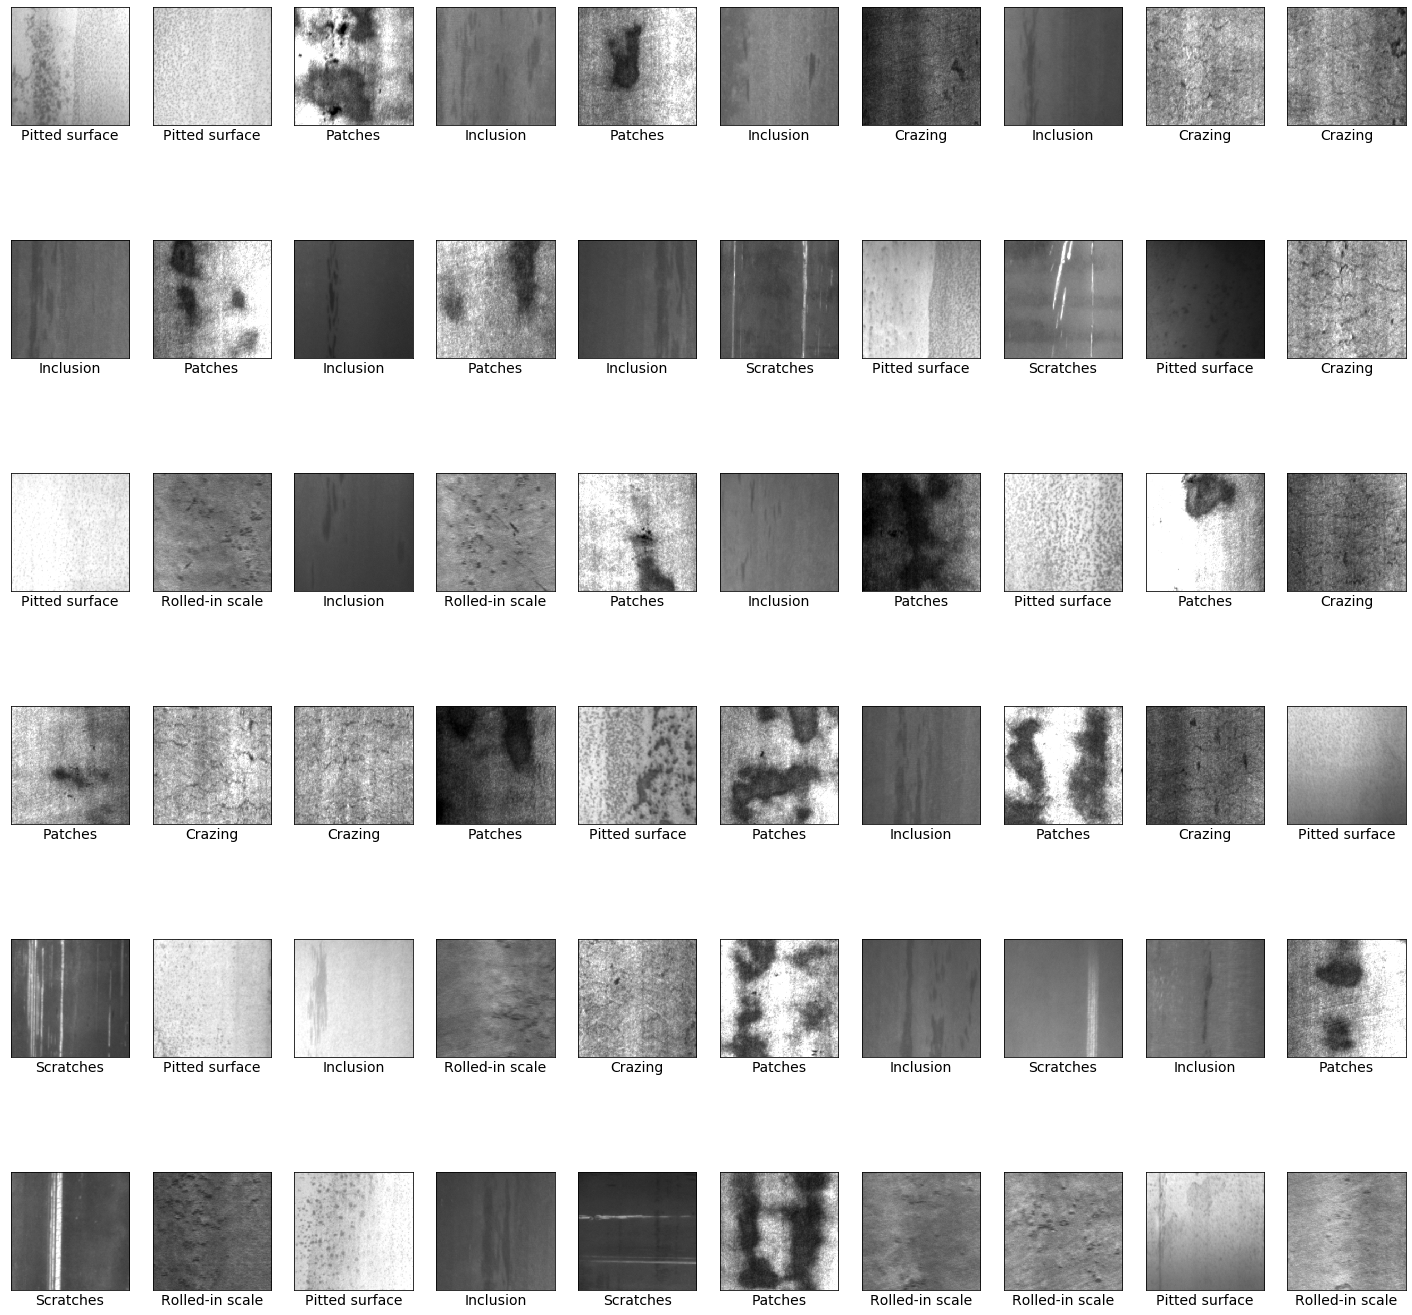

In [6]:
# 觀察資料/決定類別/清洗/調整
plt.figure(figsize=(25, 25))
k = 1
for i in range(6):
    for j in range(10):
        plt.subplot(6, 10, k)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(dataset_images[i*300+j], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,
        # which is why you need the extra index
        plt.xlabel(class_name[np.argmax(dataset_labels[i*300+j], axis=-1)], fontsize=14)
        k += 1
plt.show()

## 選擇模型

* 使用場域
* 準確率
* 辨識速度

<img src="img/各種模型效能比較.jpg" alt="architecture" align=center />

### Demo使用Inceptionv3 架構

* Inception(GoogLeNet)在2014年ILSVRC的分類比賽中拿到了第一名，GoogLeNet使用Inception的結構來取代了原本的卷積層，不同於VGG或是AlexNet加深網路的概念，而他的訓練參數也比AlexNet少上好幾倍，準確率相對更好。
* 目前使用Inception v3版本作為範例，是廣泛使用的圖片辨識模型，於 ImageNet 資料集達到 78.1% 以上的準確率。這個模型是眾研究人員長年投入大量心力的心血結晶，並以 Szegedy 等人合著的原始論文《Rethinking the Inception Architecture for Computer Vision》為依據
* 模型本身是由對稱及非對稱的建構基礎組成，其中包括convolutions, average pooling, max pooling, concats, dropouts, fully connected層。Batchnorm 在整個模型中廣泛使用，並套用至啟動輸入，損失值則透過 Softmax 計算。
* 整個網路架構如下所示，其深度為42層
* 參數總計: 22,854,950

<img src="img/Inceptionv3.png" alt="architecture" align=center />




1. 論文來源:https://arxiv.org/abs/1512.00567 
2. 圖片來源:https://cloud.google.com/tpu/docs/inception-v3-advanced

## 載入模型

In [7]:
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 6
# conv_size = 32

# parameters for training
batch_size = 256
num_epochs = 100
learning_rate = 0.001

# load MobileNet from Keras
InceptionV3_model = InceptionV3(
    include_top=False, weights=None, input_shape=input_shape)
# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
model = Model(inputs=InceptionV3_model.input, outputs=Custom_Output)

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

## 模型參數

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 訓練模型

相關參數設定：
* batch_size=256
* epochs=100
* learning_rate=0.001

### 訓練集分配
#### train/validation/test (6:2:2)

- train:用作訓練模型
- validation:更新模型參數
- test:最終模型效能測試

<img src="img/dataset.JPG" width="75%" height="75%" align="left"/>



In [9]:
# clear temp
!rm -rf logs ;mkdir logs

In [10]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
time_now = time.time()
callbacks = [
    ReduceLROnPlateau(verbose=0),
    TQDMNotebookCallback(leave_inner=False, leave_outer=True),
    TensorBoard(log_dir='logs', histogram_freq=1)
]

# train the model
history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=(val_images, val_labels),
                    callbacks=callbacks)
gup_time = time.time()-time_now
print("總共耗時:"+format(gup_time, '.2f')+'s')


總共耗時:323.01s


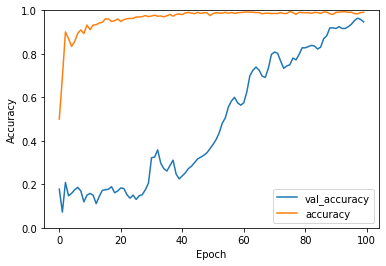

In [11]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## TensorBoard in notebook

note:目前容器預設是關閉tb服務，需要手動啟用。
1. 容器管理頁面，開啟關聯port。例如：目標埠: 5000 對外埠: 54558
2. 至terminals中 cd ~/your_Lab_NEU/
3. 啟用TB: $tensorboard --logdir logs --port 5000 #目標埠: 5000

In [14]:
# 對外埠: 54558
%tensorboard --logdir="logs" --port=54558

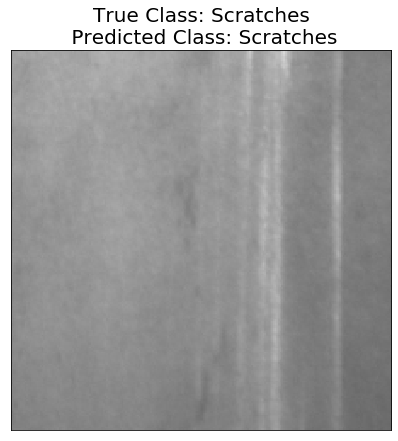

In [15]:

for index in range(0, 1800, 100):
    plt.figure(figsize=(15, 15))
    predicted_batch = model.predict(
        np.array([dataset_images[index]], dtype=float))
    predicted_id = np.argmax(predicted_batch, axis=-1)
    title = 'True Class: '+str(class_name[np.argmax(dataset_labels[index], axis=-1)]) + \
        '\n Predicted Class: '+str(class_name[int(predicted_id)])
    plt.subplot(1, 2, 1)
    plt.imshow(dataset_images[index], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=20)
    plt.show()
    time.sleep(0.3)
    display.clear_output(wait=True)

## 模型效能評估
* confusion_matrix

訓練好的模型使用測試集(Test set)評估效能

* 從資料收集到模型評估是遞迴流程，彼此間充滿不斷地修正與更新

In [16]:
# Inference all 'test set'
print("Test images =",len(test_images))
predicted_labels = []
predicted_batch = model.predict(np.array(test_images, dtype=float), batch_size=256)
predicted_labels = np.argmax(predicted_batch, axis=-1)

Test images = 360


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)
    plt.axis([-0.5, 5.5, 5.5, -0.5])
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=16)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [18]:
#!sudo pip install plotly

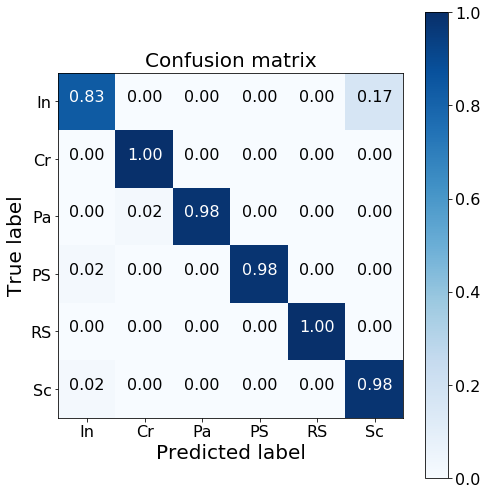

In [19]:
plt.figure(figsize=(7, 7))
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=-1), predicted_labels)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      normalize=True, title='Confusion matrix')
plt.show()

## TWCC服務與效能實例

https://www.twcc.ai/

### 三大服務領域
<img src="img/TWCC三大服務類別.jpg" width="95%" height="95%" align=left />


### 協助企業成效

* 減少90%訓練時間：博遠智能
* 提升效能498倍：雲像科技
* 改善23%的準確度：雲守護安控

<img src="img/TWCC Introduction (NCHC)_v2_企業案例實測效能.jpg" width="95%" height="95%" align=left />

## AI 產業訓練服務

國網中心的AI 產業訓練，是以企業為服務對象，藉由需求訪談了解企業實際的AI策略和應用需求，設計規劃系列AI課程內容，並透過提供個別企業的AI相關課程教學來提升人才技術能力，協助企業將AI技術於場域內落地實現，創造企業的新價值，也藉此達成產業升級、產業AI化的國家級目標。

https://www.nchc.org.tw/Page?itemid=13&mid=20


<img src="img/AI 產業訓練.jpg" width="95%" height="95%" align=left />